<a href="https://colab.research.google.com/github/aminekhasteh/DeepLearningFinalReport2020/blob/master/CNN_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
import numpy as np
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
main_dir = '/content/drive/My Drive/Colab Notebooks/Breast Cancer'

In [32]:
csv_stage = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Breast Cancer/brca-clinicalforwiki_TCIA.xlsx')

Converting the training data into tensor

In [33]:
training_names = os.listdir(main_dir + '/' + 'Training')
names=training_names[0]
miz = PIL.Image.open(main_dir + '/' + 'Training/' + names)
miz = miz.convert("L")
new = np.asarray(miz)
new_normalised = new/255
training_tensor = np.expand_dims(new_normalised, axis=0)
Y = [csv_stage.loc[csv_stage['bcr_patient_barcode'] == training_names[0][:-10]]['ajcc_neoplasm_disease_stage'].values[0]]
j=1
for names in training_names[1:]:
    Y.append(csv_stage.loc[csv_stage['bcr_patient_barcode'] == training_names[j][:-10]]['ajcc_neoplasm_disease_stage'].values[0])
    j=j+1
    miz = PIL.Image.open(main_dir + '/' + 'Training/' + names)
    miz = miz.convert("L")
    new = np.asarray(miz)
    new_normalised = new/255
    new_tensor = np.expand_dims(new_normalised, axis=0)
    #print(new_tensor.shape)
    training_tensor = np.concatenate((training_tensor, new_tensor), axis=0)

In [34]:
training_tensor.shape

(594, 256, 256)

Converting the testing data into tensor:

In [35]:
testing_names = os.listdir(main_dir + '/' + 'Testing')
names=testing_names[0]
miz1 = PIL.Image.open(main_dir + '/' + 'Testing/' + names)
miz1 = miz.convert("L")
new1 = np.asarray(miz1)
new_normalised1 = new/255
testing_tensor = np.expand_dims(new_normalised1, axis=0)
Y_test = [csv_stage.loc[csv_stage['bcr_patient_barcode'] == testing_names[0][:-10]]['ajcc_neoplasm_disease_stage'].values[0]]
k = 1
for names in testing_names[1:]:
    Y_test.append(csv_stage.loc[csv_stage['bcr_patient_barcode'] == testing_names[k][:-10]]['ajcc_neoplasm_disease_stage'].values[0])
    k=k+1
    miz = PIL.Image.open(main_dir + '/' + 'Testing/' + names)
    miz = miz.convert("L")
    new = np.asarray(miz)
    new_normalised = new/255
    new_tensor = np.expand_dims(new_normalised, axis=0)
    #print(new_tensor.shape)
    testing_tensor = np.concatenate((testing_tensor, new_tensor), axis=0)

In [36]:
testing_tensor.shape

(152, 256, 256)

Expanding the dataset one more time, we do this so the format of our data is right for training.

In [37]:
training_tensor = np.expand_dims(training_tensor, axis=3)
testing_tensor = np.expand_dims(testing_tensor, axis=3)

Description of our dataset:

In [38]:
print('Training shape:', training_tensor.shape)
print(training_tensor.shape[0], 'sample,',training_tensor.shape[1] ,'x',training_tensor.shape[2] ,'size grayscale image.\n')
print('Test shape:', testing_tensor.shape)
print(testing_tensor.shape[0], 'sample,',testing_tensor.shape[1] ,'x',testing_tensor.shape[2] ,'size grayscale image.\n')

Training shape: (594, 256, 256, 1)
594 sample, 256 x 256 size grayscale image.

Test shape: (152, 256, 256, 1)
152 sample, 256 x 256 size grayscale image.



Looking at the normalized transformed to tensor images

Examples:


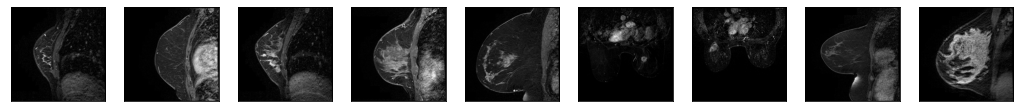

In [39]:
print('Examples:')
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(training_tensor[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Since our inputs are images, we used convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders because they perform better. Our encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder consists in a stack of Conv2D and UpSampling2D layers. 

In [40]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
input_img = Input(shape=(256, 256, 1))  # adapt this if using `channels_first` image data format
num_classes = 7

Creating dictionary of target classes

In [20]:
label_dict = {
 'Stage I':0,
 'Stage IA':1,
 'Stage II':2,
 'Stage IIA':3,
 'Stage IIB':4,
 'Stage IIIA':5,
 'Stage IIIC':6
}
num_classes = 7

Converting the response variables into categrocal dataframe.

In [21]:
from keras.utils import to_categorical

y = pd.DataFrame(Y)
y = y.replace(label_dict)

y_test = pd.DataFrame(Y_test)
y_test = y_test.replace(label_dict)

# Change the labels from categorical to one-hot encoding
train_Y = to_categorical(y)
test_Y = to_categorical(y_test)

Defining the fully connected layers:

In [22]:
from keras.layers.advanced_activations import LeakyReLU
full_model = Sequential()
full_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(256,256,1)))
full_model.add(LeakyReLU(alpha=0.1))
full_model.add(MaxPooling2D((2, 2),padding='same'))
full_model.add(Dropout(0.25))
full_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
full_model.add(LeakyReLU(alpha=0.1))
full_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
full_model.add(Dropout(0.25))
full_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
full_model.add(LeakyReLU(alpha=0.1))                  
full_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
full_model.add(Dropout(0.4))
full_model.add(Flatten())
full_model.add(Dense(128, activation='linear'))
full_model.add(LeakyReLU(alpha=0.1))           
full_model.add(Dropout(0.3))
full_model.add(Dense(num_classes, activation='softmax'))

In [23]:
full_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 64)        0

In [24]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy']) 

In [25]:
full_model_cluster = full_model.fit(training_tensor, train_Y, 
                                batch_size=32,
                                epochs=10,
                                validation_data=(testing_tensor, test_Y), 
                                shuffle=True)

Epoch 1/10
19/19 [==============================] - 2s 120ms/step - loss: 1.7391 - accuracy: 0.3569 - val_loss: 1.5437 - val_accuracy: 0.3750
Epoch 2/10
19/19 [==============================] - 2s 102ms/step - loss: 1.2667 - accuracy: 0.5471 - val_loss: 1.2555 - val_accuracy: 0.6118
Epoch 3/10
19/19 [==============================] - 2s 102ms/step - loss: 0.8083 - accuracy: 0.6970 - val_loss: 0.6001 - val_accuracy: 0.8421
Epoch 4/10
19/19 [==============================] - 2s 104ms/step - loss: 0.3852 - accuracy: 0.8805 - val_loss: 0.2382 - val_accuracy: 0.9342
Epoch 5/10
19/19 [==============================] - 2s 102ms/step - loss: 0.1369 - accuracy: 0.9579 - val_loss: 0.0758 - val_accuracy: 0.9868
Epoch 6/10
19/19 [==============================] - 2s 103ms/step - loss: 0.0489 - accuracy: 0.9781 - val_loss: 0.0506 - val_accuracy: 0.9868
Epoch 7/10
19/19 [==============================] - 2s 102ms/step - loss: 0.0745 - accuracy: 0.9747 - val_loss: 0.0523 - val_accuracy: 0.9868
Epoch 

In [26]:
test_eval = full_model.evaluate(testing_tensor, test_Y, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.01834319531917572
Test accuracy: 0.9934210777282715


This function will give us a nice confusion matrix plot:

In [27]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Model evaluation on the Test set:

In [28]:
# Results on testing
encode = full_model.predict(testing_tensor)
predicted = np.argmax(encode, axis=1)

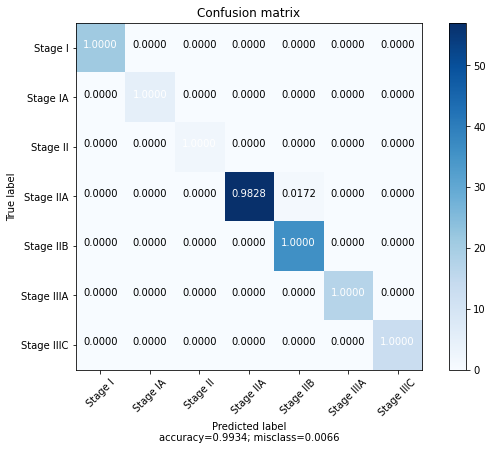

In [29]:
from sklearn.metrics import confusion_matrix
import pylab as pl
cm = confusion_matrix(y_test, predicted)
plot_confusion_matrix(cm,['Stage I','Stage IA','Stage II','Stage IIA','Stage IIB','Stage IIIA','Stage IIIC'])